# Day 7: K-means Clustering and Principal Component Analysis

In this exercise, you will implement the K-means clustering algorithm and apply it to compress an image. In the second part, you will use principal component analysis to find a low-dimensional representation of face images.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 5)
%matplotlib inline
import scipy.io
from random import sample
import scipy.misc
import scipy.linalg
import matplotlib.cm as cm

## 1 *K*-means Clustering

In this this exercise, you will implement the K-means algorithm and use it for image compression. You will first start on an example 2D dataset that will help you gain an intuition of how the K-means algorithm works. After that, you wil use the K-means algorithm for image compression by reducing the number of colors that occur in an image to only those that are most common in that image.

### 1.1 Implementing *K*-means

The K-means algorithm is a method to automatically cluster similar data examples together. Concretely, you are given a training set {$x^{(1)}, ..., x^{(m)}$} (where $x^{(i)} \in R^n)$, and want to group the data into a few cohesive "clusters". The intuition behind K-means is an iterative procedure that starts by guessing the initial centroids, and then refines this guess by repeatedly assigning examples to their closest centroids and then recomputing the centroids based on the assignments.

The inner-loop of the algorithm repeatedly carries out two steps: **(i)** Assigning each training example $x^{(i)}$ to its closest centroid, and **(ii)** Recomputing the mean of each centroid using the points assigned to it.

You will implement the two phases of the K-means algorithm separately in the next sections.

In [2]:
data = scipy.io.loadmat('data/ex7data2.mat')
X = data['X']
print(X.shape)
print(X[:5])

(300, 2)
[[ 1.84207953  4.6075716 ]
 [ 5.65858312  4.79996405]
 [ 6.35257892  3.2908545 ]
 [ 2.90401653  4.61220411]
 [ 3.23197916  4.93989405]]


In [3]:
# Choose the number of centroids
K = 3
# Choose the initial centroids
initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

In [4]:
# Visualizing the data
def plotData(X, centroids, idxs=None):
    '''Function to plot the data and color it accordingly.
    Parameters:
        X: the data, which is (m, n) matrix
           (where m is the # of points, n is the # of features).
        centroids: the centroid seed matrix, which is (K, n) matrix
           (where K is the # of centroids (clusters)).
        idxs: a (m, 1) vector of cluster indices per point in X.'''
    
    colors = ['r', 'g', 'b', 'darkorange', 'salmon', 'olivedrab']
    
    # Assert input
    #assert X.shape[0] == centroids[0][0].shape
    assert centroids[-1].shape[0] <= len(colors)
    
    # If idxs is supplied, divide up X into colors
    if idxs is not None:
        assert idxs.shape[0] == X.shape[0]
        subX = []
        for x in range(centroids[0].shape[0]):
            subX.append(np.array([X[i] for i in range(X.shape[0]) if idxs[i] == x]))
    else:
        subX = [X]
    
    fig = plt.figure(figsize=(8,5))
    for x in range(len(subX)):
        newX = subX[x]
        plt.plot(newX[:,0], newX[:,1], 'o', color=colors[x],
                 alpha=0.75, label='Data points: Cluster {}'.format(x))
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Plot of X points')
    
    # Drawing a history of centroid movement
    tempx, tempy = [], []
    for centroid in centroids:
        tempx.append(centroid[:, 0])
        tempy.append(centroid[:, 1])
    
    for x in range(len(tempx[0])):
        plt.plot(tempx, tempy, 'kx--')
    
    leg = plt.legend(loc=4, framealpha=0.5)

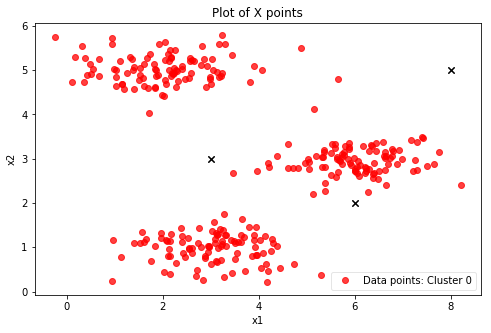

In [5]:
plotData(X, [initial_centroids])

#### 1.1.1 Finding closest centroids

In the "cluster assignment" phase of the K-means algorithm, the algorithm assigns every training example $x^{(i)}$ to its closest centroid, given the current positions of centroids. Specifically, for every example $i$ we set
$\space c^{(i)} := j$ that minimizes $||x^{(i)} - \mu_j||^2$ where $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$, and $\mu_j$ is the position (value) of the $j$’th centroid.

In [6]:
def distSquared(point1, point2):
    assert point1.shape == point2.shape
    return np.sum(np.square(point1-point2))

In [7]:
def findClosestCentroids(X, centroids):
    '''Implement cluster assignment phase of the K-means algorithm.
    Parameters:
        X: the data, which is (m, n) matrix
           (where m is the # of points, n is the # of features).
        centroids: the centroid seed matrix, which is (K, n) matrix
           (where K is the # of centroids (clusters)).
    Return:
        idxs: a (m, 1) vector of cluster indices per point in X.'''
    
    idxs = np.zeros((X.shape[0], 1))
    
    for x in range(idxs.shape[0]):
        point = X[x]
        # Compare this point to each centroid,
        # keep track the index of the centroids that is closest.
        min_dist, idx = None, 0
        for i in range(centroids.shape[0]):
            centroid = centroids[i]
            dist = distSquared(centroid, point)
            if min_dist == None or dist < min_dist :
                min_dist = dist
                idx = i
        idxs[x] = idx
    
    return idxs

In [8]:
idxs = findClosestCentroids(X, initial_centroids)
print(idxs[:5].flatten())

[ 0.  2.  1.  0.  0.]


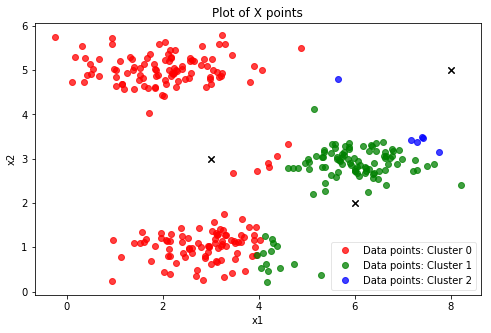

In [9]:
plotData(X,[initial_centroids],idxs)

#### 1.1.2 Computing centroid means

Given assignments of every point to a centroid, the second phase of the algorithm recomputes, for each centroid, the mean of the points that were assigned to it. Specifically, for every centroid $k$ we set
$$\mu_k := \frac{1}{|C_k|}\sum_{i\in C_k} x^{(i)}$$
where $C_k$ is the set of examples that are assigned to centroid $k$. 

In [10]:
def computeCentroids(X, idxs):
    '''Implement computing centroid means.
    Parameters:
        X: the data, which is (m, n) matrix
           (where m is the # of points, n is the # of features).
        idxs: a (m, 1) vector of cluster indices per point in X.
    Return:
        A new centroid matrix, which is (K, n) matrix
           (where K is the # of centroids (clusters)).'''
    subX = []
    for x in range(len(np.unique(idxs))):
        subX.append(np.array([X[i] for i in range(X.shape[0]) if idxs[i] == x]))
    return np.array([np.mean(thisX,axis=0) for thisX in subX])

### 1.2 K-means on example dataset

In [11]:
def runKMeans(X, initial_centroids, K, n_iter):
    """
    Function run the K-means algorithm on a toy 2D dataset to 
    help you understand how K-means works.
    """
    centroid_history = []
    current_centroids = initial_centroids
    for myiter in range(n_iter):
        centroid_history.append(current_centroids)
        idxs = findClosestCentroids(X,current_centroids)
        current_centroids = computeCentroids(X,idxs)
        
    return idxs, centroid_history

In [12]:
idxs, centroid_history = runKMeans(X, initial_centroids, K=3, n_iter=10)

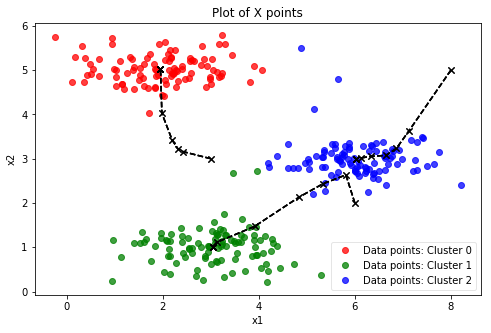

In [13]:
plotData(X,centroid_history,idxs)

### 1.3 Random initialization

In practice, a good strategy for initializing the centroids is to select random examples from the training set.

In [14]:
def kMeansInitCentroids(X, K):
    rand_indices = sample(range(0, X.shape[0]), K)
    return np.array([X[i] for i in rand_indices])

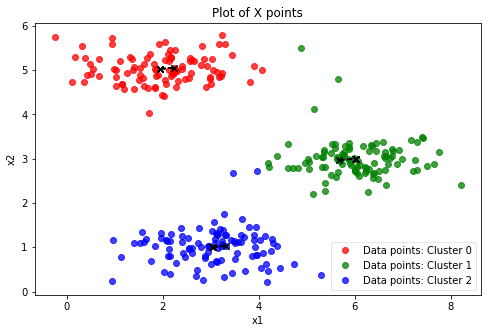

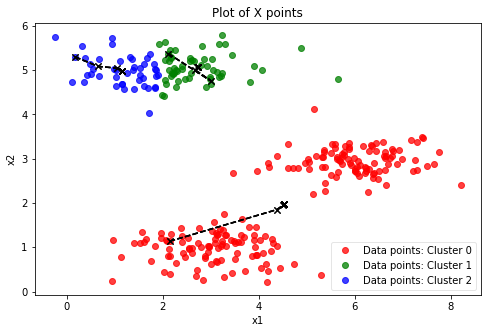

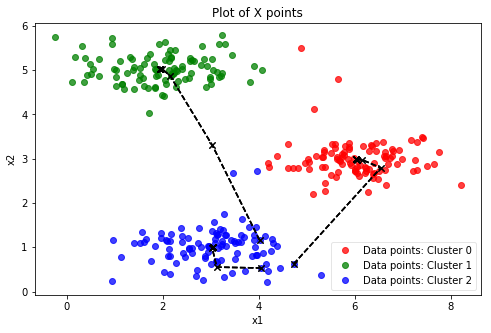

In [15]:
# Let's choose random initial centroids 3 times and see the resulting
for x in range(3):
    idxs, centroid_history = runKMeans(X, kMeansInitCentroids(X, K=3),
                                       K=3, n_iter=10)
    plotData(X, centroid_history, idxs)

### 1.4 Image compression with *K*-means

In this exercise, you will use the K-means algorithm to select the 16 colors that will be used to represent the compressed image.

(128, 128, 3)


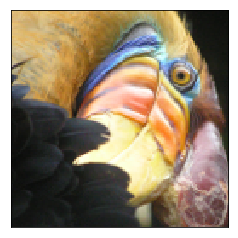

In [16]:
img = scipy.misc.imread('data/bird_small.png')
print(img.shape)
plt.imshow(img);
plt.xticks([]); plt.yticks([]);

In [17]:
# Scaling
img = img / 255.

# Unroll the image
img = img.reshape(-1, 3)

# Run k-means on this data, forming 16 clusters, with random initialization
K = 16
idxs, centroid_history = runKMeans(img, kMeansInitCentroids(img, K),
                                   K, n_iter=10)

In [18]:
# Now I have 16 centroids, each representing a color.
# Let's assign an index to each pixel in the original image dictating
# which of the 16 colors it should be.
idxs = findClosestCentroids(img, centroid_history[-1])

In [19]:
final_centroids = centroid_history[-1]
# Now loop through the original image and form a new image
# that only has 16 colors in it.
final_image = np.zeros((idxs.shape[0], 3))
for x in range(final_image.shape[0]):
    final_image[x] = final_centroids[int(idxs[x])]

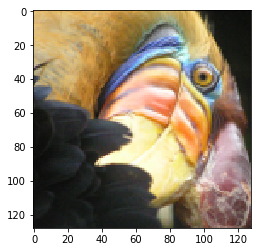

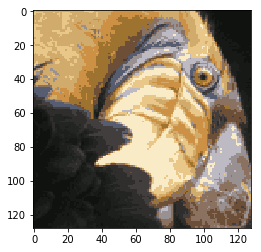

In [20]:
# Reshape the original image and the new, final image and draw them
# To see what the "compressed" image looks like
plt.figure()
dummy = plt.imshow(img.reshape(128, 128, 3))
plt.figure()
dummy = plt.imshow(final_image.reshape(128, 128, 3))

## 2 Pricipal Component Analysis (PCA)

In this exercise, you will use principal component analysis (PCA) to perform dimensionality reduction. You will first experiment with an example 2D dataset to get intuition on how PCA works, and then use it on a bigger dataset of 5000 face image dataset.

### 2.1 Example Dataset

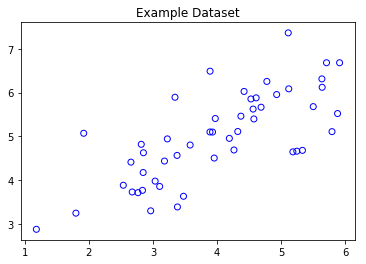

In [21]:
data2 = scipy.io.loadmat('data/ex7data1.mat')
X = data2['X']

# Plot
plot = plt.scatter(X[:,0], X[:,1], facecolor='none', edgecolors='b');
plt.title('Example Dataset');

### 2.2 Implementing PCA

In this part of the exercise, you will implement PCA. PCA consists of two computational steps: First, you compute the covariance matrix of the data. Then, you use Octave/MATLAB’s **SVD** (in Python is `scipy.linalg.svd`) function to compute the eigenvectors $U_1,U_2, ...,U_n$. These will correspond to the principal components of variation in the data.

Before using PCA, it is important to first normalize the data by subtracting the mean value of each feature from the dataset, and scaling each dimension so that they are in the same range.

In [22]:
def featureNormalize(X):
    means = np.mean(X, axis=0)
    X_norm = X - means
    stds = np.std(X_norm, axis=0)
    X_norm /= stds
    return means, stds, X_norm

After normalizing the data, you can run PCA to compute the principal components. First, you should compute the covariance
matrix of the data, which is given by: $$\Sigma = \frac{1}{m}X^TX$$
where $X$ is the data matrix with examples in rows, and $m$ is the number of examples. Note that $\Sigma$ is a *n* x *n* matrix and not the summation operator.

After computing the covariance matrix, you can run SVD on it to compute the principal components by built-in function.

In [23]:
def pca(X_norm):
    # Compute the covariance matrix
    cov_matrix = X_norm.T.dot(X_norm)/X_norm.shape[0]
    # Run single value decomposition to get the U principal component matrix
    U, S, V = scipy.linalg.svd(cov_matrix, full_matrices=True, compute_uv=True)
    return U, S, V

In [24]:
# Feature normalize
means, stds, X_norm = featureNormalize(X)
# Run SVD
U, S, V = pca(X_norm)

Top principal component is  [-0.70710678 -0.70710678]


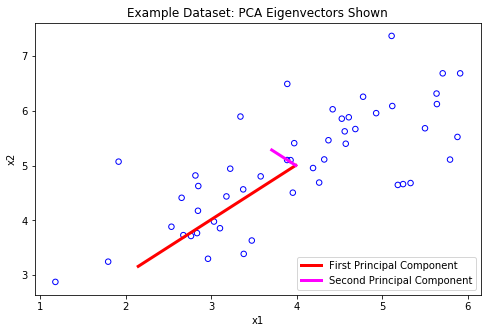

In [25]:
# The script will also output the top principal component (eigenvector) found, 
# and you should expect to see an output of about [-0.707 -0.707].
print('Top principal component is ', U[:,0])

#Quick plot, now including the principal component
plt.figure(figsize=(8,5))
plot = plt.scatter(X[:,0], X[:,1], s=30, facecolors='none', edgecolors='b')
plt.title("Example Dataset: PCA Eigenvectors Shown")
plt.xlabel('x1')
plt.ylabel('x2')

# To draw the principal component, you draw them starting
# at the mean of the data
plt.plot([means[0], means[0] + 1.5*S[0]*U[0,0]], 
         [means[1], means[1] + 1.5*S[0]*U[0,1]],
         color='red',linewidth=3,
         label='First Principal Component')
plt.plot([means[0], means[0] + 1.5*S[1]*U[1,0]], 
         [means[1], means[1] + 1.5*S[1]*U[1,1]],
         color='fuchsia',linewidth=3,
         label='Second Principal Component')
leg = plt.legend(loc=4)

### 2.3 Dimensionality Reduction with PCA

After computing the principal components, you can use them to reduce the feature dimension of your dataset by projecting each example onto a lower dimensional space, $x^{(i)}\rightarrow z^{(i)}$ (e.g., projecting the data from 2D to 1D). In
this part of the exercise, you will use the eigenvectors returned by PCA and project the example dataset into a 1-dimensional space.

In practice, if you were using a learning algorithm such as linear regression or perhaps neural networks, you could now use the projected data instead of the original data. By using the projected data, you can train your model faster as there are less dimensions in the input.

#### 2.3.1 Projecting the data onto the principal components

In [26]:
def projectData(X, U, K):
    '''Function that computes the reduced data representation when
    projecting only on to the top "K" eigenvectors'''
    
    # Reduced U is the first "K" columns in U
    U_reduced = U[:, :K]
    z = X.dot(U_reduced)
    return z

In [27]:
# The code will project the first example onto the first dimension and you should see a value
# of about 1.481 (or possibly -1.481, if you got −U1 instead of U1).
z = projectData(X_norm, U, 1)
print('Projection of the first example is {:.3f}'.format(float(z[0])))

Projection of the first example is 1.496


#### 2.3.2 Reconstructing an approximation of the data

After projecting the data onto the lower dimensional space, you can approximately recover the data by projecting them back onto the original high dimensional space. 

In [28]:
def recoverData(Z, U, K):
    U_reduced = U[:, :K]
    X_approx = Z.dot(U_reduced.T)
    return X_approx

In [29]:
# The code will recover an approximation of the first example and you should see a value of
# about [-1.047 -1.047].
X_rec = recoverData(z, U, 1)
print('Recovered approximation of the first example is ',X_rec[0])

Recovered approximation of the first example is  [-1.05805279 -1.05805279]


#### 2.3.3 Visualizing the projections

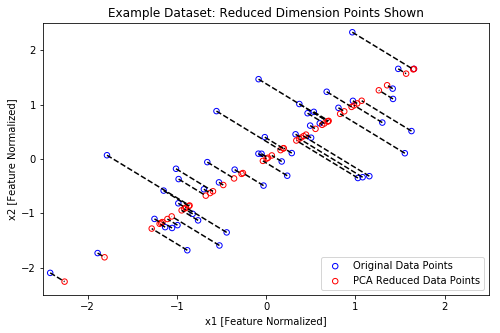

In [30]:
plt.figure(figsize=(8,5))
plt.scatter(X_norm[:,0], X_norm[:,1], s=30, facecolors='none', 
                   edgecolors='b',label='Original Data Points')
plt.scatter(X_rec[:,0], X_rec[:,1], s=30, facecolors='none', 
                   edgecolors='r',label='PCA Reduced Data Points')

for x in range(X_norm.shape[0]):
    plt.plot([X_norm[x,0], X_rec[x,0]], [X_norm[x,1], X_rec[x,1]], 'k--')
    
plt.title("Example Dataset: Reduced Dimension Points Shown")
plt.xlabel('x1 [Feature Normalized]')
plt.ylabel('x2 [Feature Normalized]')
plt.legend(loc=4)
plt.xlim((-2.5,2.5));
plt.ylim((-2.5,2.5));

### 2.4 Face Image Dataset

In this part of the exercise, you will run PCA on face images to see how it can be used in practice for dimension reduction. 

In [31]:
data3 = scipy.io.loadmat('data/ex7faces.mat')
X = data3['X']
print(X.shape)

(5000, 1024)


In [32]:
def getDatumImg(row):
    '''Function that is handed a single np array with shape 1x1032,
    crates an image object from it, and returns it.'''
    width, height = 32, 32
    square = row.reshape(width, height)
    return square.T

def displayData(X, rows=10, cols=10):
    '''Function that picks the first 100 rows from X, creates an image from each,
    then stitches them together into a 10x10 grid of images, and shows it.'''
    w, h = 32, 32
    big_pic = np.zeros((h*rows, w*cols))
    row, col = 0, 0
    for i in range(rows*cols):
        if col == cols:
            row += 1
            col = 0
        img = getDatumImg(X[i])
        big_pic[row*h:row*h+img.shape[0], col*w:col*w+img.shape[1]] = img
        col += 1
    fig = plt.figure(figsize=(10, 10))
    image = scipy.misc.toimage(big_pic)
    plt.imshow(image, cmap=cm.Greys_r)
    plt.xticks([]); plt.yticks([]);

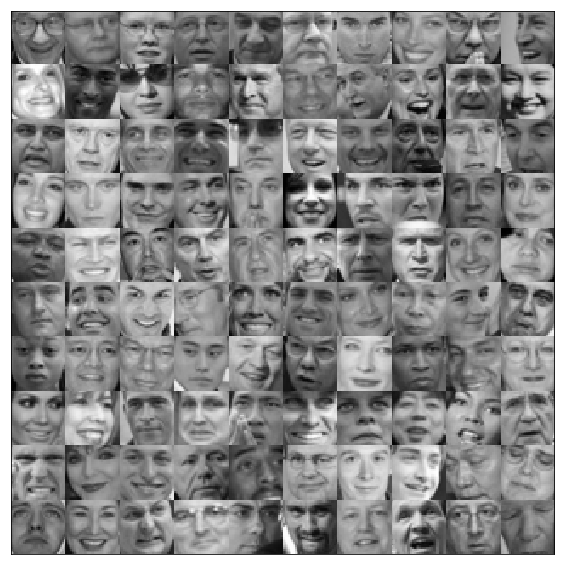

In [33]:
displayData(X)

#### 2.4.1 PCA on Faces

In [34]:
# Feature normalize
means, stds, X_norm = featureNormalize(X)
# Run SVD
U, S, V = pca(X_norm)

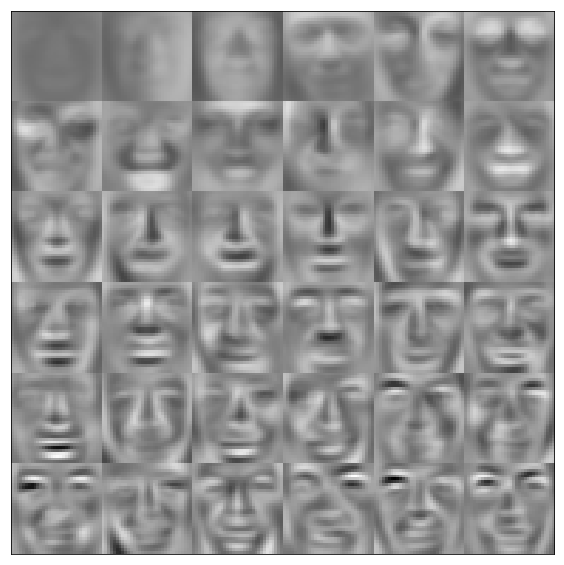

In [35]:
# Visualize the top 36 eigenvectors found
displayData(U[:,:36].T, rows=6, cols=6)

#### 2.4.2 Dimensionality Reduction

Now that you have computed the principal components for the face dataset, you can use it to reduce the dimension of the face dataset. This allows you to use your learning algorithm with a smaller input size (e.g., 100 dimensions) instead of the original 1024 dimensions. This can help speed up your learning algorithm.

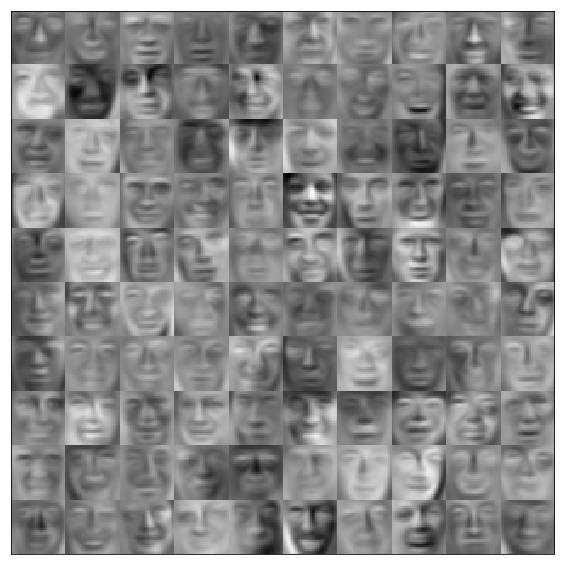

In [36]:
# Project each image down to 36 dimensions
z = projectData(X_norm, U, K=36)

# Attempt to recover the original data
X_rec = recoverData(z, U, K=36)

# Plot the dimension-reduced data
displayData(X_rec)